# Simple Analyses for Regression

This notebook contains a variety of simple analyses - simple regressions, random forests, GMMs etc...

## 1. Linear Regression

This approach seeks to fit a straight line of $mx + b$ though the dataset.

In [28]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
from collections import namedtuple

In [2]:
dataset_df = load_diabetes(as_frame=True).frame
dataset_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [3]:
training_data, test_data = train_test_split(dataset_df, test_size=0.2, random_state=42)

In [4]:
training_data_X = training_data.drop(columns=["target"])
training_data_y = training_data["target"]
test_data_X = test_data.drop(columns=["target"])
test_data_y = test_data["target"]


In [22]:
model = LinearRegression().fit(training_data_X, training_data_y)
results = model.predict(test_data_X)
rmse = np.sqrt(mean_squared_error(test_data_y, results))
msle = mean_squared_log_error(test_data_y, results)
r2 = r2_score(test_data_y, results)

print(f"Mean Squared Log Error: {msle}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2 Score: {r2}")

Mean Squared Log Error: 0.17696674535345125
Root Mean Squared Error: 53.85344583676593
R2 Score: 0.4526027629719195


## 2. Polynomial Regression

For the model $ y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3x^3 + \dots + \beta_nx^n + \epsilon $

for a dependent variable $y$, where $x$ is a vector of independent variables with $\beta$ parameters, and $\epsilon$ random error.

### 2.1 Polynomial Features

This approach transforms the data as if it were a polynomial curve of a given degree. The now "straightened" function is then regressed linearly.

In [7]:
from sklearn.preprocessing import PolynomialFeatures

In [24]:
degrees = range(1, 12)

polynomial_model = namedtuple("PolynomialModel", ["model", "degree", "rmse",  "r2"])

models = []

for degree in tqdm(degrees):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    polynomial_features_x = polynomial_features.fit_transform(training_data_X)
    model = LinearRegression().fit(polynomial_features_x, training_data_y)

    results = model.predict(polynomial_features.fit_transform(test_data_X))
    rmse = np.sqrt(mean_squared_error(test_data_y, results))
    r2 = r2_score(test_data_y, results)
    models.append(polynomial_model(model, degree, rmse, r2))

100%|██████████| 11/11 [00:42<00:00,  3.85s/it]


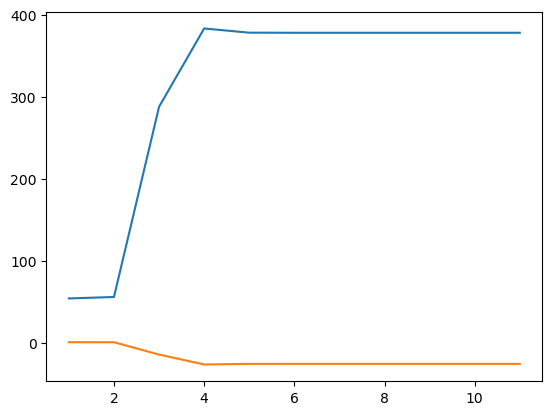

Best Model by RMSE: PolynomialModel(model=LinearRegression(), degree=1, rmse=53.85344583676593, r2=0.4526027629719195)
Best Model by R2: PolynomialModel(model=LinearRegression(), degree=1, rmse=53.85344583676593, r2=0.4526027629719195)


In [26]:
plt.plot([model.degree for model in models], [model.rmse for model in models])
plt.plot([model.degree for model in models], [model.r2 for model in models])
plt.show()

best_rmse_model = min(models, key=lambda model: model.rmse)
best_r2_model = max(models, key=lambda model: model.r2)

print(f"Best Model by RMSE: {best_rmse_model}")
print(f"Best Model by R2: {best_r2_model}")

Trying with Ridge regression instead

In [29]:
degrees = range(1, 12)

polynomial_model = namedtuple("PolynomialModel", ["model", "degree", "rmse",  "r2"])

models = []

for degree in tqdm(degrees):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    polynomial_features_x = polynomial_features.fit_transform(training_data_X)
    model = Ridge().fit(polynomial_features_x, training_data_y)

    results = model.predict(polynomial_features.fit_transform(test_data_X))
    rmse = np.sqrt(mean_squared_error(test_data_y, results))
    r2 = r2_score(test_data_y, results)
    models.append(polynomial_model(model, degree, rmse, r2))

100%|██████████| 11/11 [00:05<00:00,  2.02it/s]


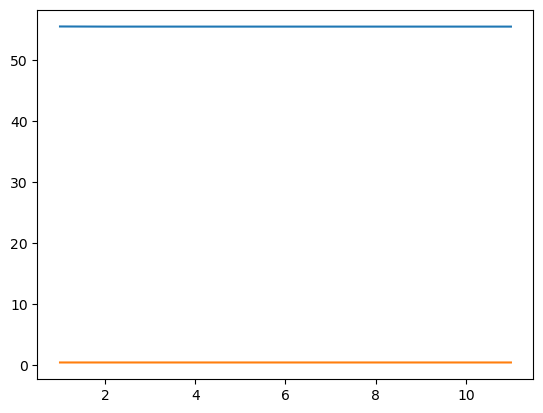

Best Model by RMSE: PolynomialModel(model=Ridge(), degree=10, rmse=55.453646300170874, r2=0.4195887483129498)
Best Model by R2: PolynomialModel(model=Ridge(), degree=10, rmse=55.453646300170874, r2=0.4195887483129498)


In [30]:
plt.plot([model.degree for model in models], [model.rmse for model in models])
plt.plot([model.degree for model in models], [model.r2 for model in models])
plt.show()

best_rmse_model = min(models, key=lambda model: model.rmse)
best_r2_model = max(models, key=lambda model: model.r2)

print(f"Best Model by RMSE: {best_rmse_model}")
print(f"Best Model by R2: {best_r2_model}")

### 2.2 Cubic Spline Implementation

Uses a set of basis splines to help avoid Runge artefacts in higher order polynomial regression. Far less compute heavy for decent approximation.

In [31]:
from sklearn.preprocessing import SplineTransformer

In [45]:
splines = SplineTransformer(degree=3, n_knots=2, include_bias=False)
splined_x = splines.fit_transform(training_data_X)
model = LinearRegression().fit(splined_x, training_data_y)

results = model.predict(splines.fit_transform(test_data_X))
rmse = np.sqrt(mean_squared_error(test_data_y, results))
r2 = r2_score(test_data_y, results)

print(f"R2 Score: {r2}")
print(f"Root Mean Squared Error: {rmse}")

R2 Score: -9.40783890298262
Root Mean Squared Error: 234.82399767084385


## Random Forests Regression

A bagging approach of breaking down the data into a set of weak decision trees. predicted values are estimated based on a bagged output of the estimator trees.

In [46]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
rf_regression_model = RandomForestRegressor().fit(training_data_X, training_data_y)
results = rf_regression_model.predict(test_data_X)

rmse = np.sqrt(mean_squared_error(test_data_y, results))
r2 = r2_score(test_data_y, results)

print(f"R2 Score: {r2}")
print(f"Root Mean Squared Error: {rmse}")

R2 Score: 0.4203164889104828
Root Mean Squared Error: 55.41887050333278


## 4 Gradient Boosting

### 4.1 Gradient Boosting for Regression

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

In [51]:
model = GradientBoostingRegressor(learning_rate=0.01, loss="huber").fit(training_data_X, training_data_y)
results = model.predict(test_data_X)

rmse = np.sqrt(mean_squared_error(test_data_y, results))
r2 = r2_score(test_data_y, results)

print(f"R2 Score: {r2}")
print(f"Root Mean Squared Error: {rmse}")

R2 Score: 0.40213237635177834
Root Mean Squared Error: 56.28137698753728


### 4.2 XGBoost

In [53]:
from xgboost import XGBRegressor

In [55]:
model = XGBRegressor().fit(training_data_X, training_data_y)
results = model.predict(test_data_X)

rmse = np.sqrt(mean_squared_error(test_data_y, results))
r2 = r2_score(test_data_y, results)

print(f"R2 Score: {r2}")
print(f"Root Mean Squared Error: {rmse}")

/Users/richardstrange/opt/miniconda3/envs/ml-portfolio/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/richardstrange/opt/miniconda3/envs/ml-portfolio/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/richardstrange/opt/miniconda3/envs/ml-portfolio/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/richardstrange/opt/miniconda3/envs/ml-portfolio/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and wi

R2 Score: 0.22857599305390852
Root Mean Squared Error: 63.930598708670935


/Users/richardstrange/opt/miniconda3/envs/ml-portfolio/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/richardstrange/opt/miniconda3/envs/ml-portfolio/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/richardstrange/opt/miniconda3/envs/ml-portfolio/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/richardstrange/opt/miniconda3/envs/ml-portfolio/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and wi

## 5. Support Vector Machines

In [61]:
from sklearn.svm import SVR

In [62]:
model = SVR(kernel="rbf").fit(training_data_X, training_data_y)
results = model.predict(test_data_X)

rmse = np.sqrt(mean_squared_error(test_data_y, results))
r2 = r2_score(test_data_y, results)

print(f"R2 Score: {r2}")
print(f"Root Mean Squared Error: {rmse}")

R2 Score: 0.18211365770500287
Root Mean Squared Error: 65.82769899151941


## 6. Lasso

In [66]:
from sklearn.linear_model import Lasso

In [67]:
model = Lasso().fit(training_data_X, training_data_y)
results = model.predict(test_data_X)

rmse = np.sqrt(mean_squared_error(test_data_y, results))
r2 = r2_score(test_data_y, results)

print(f"R2 Score: {r2}")
print(f"Root Mean Squared Error: {rmse}")

R2 Score: 0.3575918767219115
Root Mean Squared Error: 58.340172450954185


## 7. ElasticNet

In [68]:
from sklearn.linear_model import ElasticNet

In [69]:
model = ElasticNet().fit(training_data_X, training_data_y)
results = model.predict(test_data_X)

rmse = np.sqrt(mean_squared_error(test_data_y, results))
r2 = r2_score(test_data_y, results)

print(f"R2 Score: {r2}")
print(f"Root Mean Squared Error: {rmse}")

R2 Score: -0.0024652131111431164
Root Mean Squared Error: 72.87806818015876


## 8. Bayesian Ridge

In [71]:
from sklearn.linear_model import BayesianRidge

In [72]:
model = BayesianRidge().fit(training_data_X, training_data_y)
results = model.predict(test_data_X)

rmse = np.sqrt(mean_squared_error(test_data_y, results))
r2 = r2_score(test_data_y, results)

print(f"R2 Score: {r2}")
print(f"Root Mean Squared Error: {rmse}")

R2 Score: 0.4579690718827284
Root Mean Squared Error: 53.588824483791385
